In [1]:
import sqlite3
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools import eval_measures
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import covid table as dataframe
con = sqlite3.connect("../Data/data.db")
covid_df = pd.read_sql_query("SELECT * FROM covid", con)
print(covid_df.dtypes)
print(covid_df.shape)
covid_df.head()

date                        object
state                       object
positiveIncrease             int64
totalTestResultsIncrease     int64
dtype: object
(18223, 4)


,date,state,positiveIncrease,totalTestResultsIncrease
0,2021-02-20 00:00:00,AK,0,0
1,2021-02-20 00:00:00,AL,774,5436
2,2021-02-20 00:00:00,AR,517,3060
3,2021-02-20 00:00:00,AZ,2047,45153
4,2021-02-20 00:00:00,CA,6668,192222


In [3]:
# Change date to datetime
covid_df['date'] = pd.to_datetime(covid_df['date'])
print(covid_df.dtypes)
covid_df.head()

date                        datetime64[ns]
state                               object
positiveIncrease                     int64
totalTestResultsIncrease             int64
dtype: object


,date,state,positiveIncrease,totalTestResultsIncrease
0,2021-02-20,AK,0,0
1,2021-02-20,AL,774,5436
2,2021-02-20,AR,517,3060
3,2021-02-20,AZ,2047,45153
4,2021-02-20,CA,6668,192222


In [4]:
# Define cutoff dates and encoding
months = [2,3,4,5,6,7,8,9]
start = [pd.Timestamp("2-15-2020"),
         pd.Timestamp("3-15-2020"),
         pd.Timestamp("4-15-2020"),
         pd.Timestamp("5-15-2020"),
         pd.Timestamp("6-15-2020"),
         pd.Timestamp("7-15-2020"),
         pd.Timestamp("8-15-2020"),
         pd.Timestamp("9-15-2020")]
end = [pd.Timestamp("3-15-2020"),
       pd.Timestamp("4-15-2020"),
       pd.Timestamp("5-15-2020"),
       pd.Timestamp("6-15-2020"),
       pd.Timestamp("7-15-2020"),
       pd.Timestamp("8-15-2020"),
       pd.Timestamp("9-15-2020"),
       pd.Timestamp("10-15-2020")]

# Include new month column
for i in range(len(months)):
    covid_df.loc[(covid_df['date']>=start[i]) & (covid_df['date']<end[i]), "month"] = months[i]

# Drop rows outside of daterange
covid_df = covid_df.dropna()
print(covid_df.shape)

covid_df.head()

(11546, 5)


,date,state,positiveIncrease,totalTestResultsIncrease,month
6579,2020-10-14,AK,155,2388,9.0
6580,2020-10-14,AL,784,5014,9.0
6581,2020-10-14,AR,1079,10677,9.0
6582,2020-10-14,AZ,901,22286,9.0
6583,2020-10-14,CA,2666,91770,9.0


In [5]:
# Groupby state and month and sum
covid_df = covid_df.groupby(['state','month']).sum()
covid_df = covid_df.reset_index()
print(covid_df.shape)
covid_df.head()

(408, 4)


,state,month,positiveIncrease,totalTestResultsIncrease
0,AK,2.0,0,136
1,AK,3.0,285,8204
2,AK,4.0,104,23414
3,AK,5.0,276,41705
4,AK,6.0,915,76006


In [6]:
# Calculate change in infections by state and month
months = [3,4,5,6,7,8,9]
states = covid_df['state'].unique()

for month in months:
    for state in states:
        curr_month = covid_df[(covid_df['month'] == month) & (covid_df['state'] == state)].positiveIncrease.item()
        prev_month = covid_df[(covid_df['month'] == month-1) & (covid_df['state'] == state)].positiveIncrease.item()
        if prev_month != 0:
            covid_df.loc[(covid_df['month'] == month) & (covid_df['state'] == state), 'change'] = \
            (curr_month-prev_month)/prev_month

# Drop na - data for month 2, and month 3 where month 2 positiveIncrease is 0
covid_df = covid_df.dropna()
print(covid_df.shape)
covid_df.head()

(355, 5)


,state,month,positiveIncrease,totalTestResultsIncrease,change
2,AK,4.0,104,23414,-0.635088
3,AK,5.0,276,41705,1.653846
4,AK,6.0,915,76006,2.315217
5,AK,7.0,2498,146456,1.730055
6,AK,8.0,2272,107484,-0.090472


In [7]:
# Get population of states
pop_df = pd.read_sql_query("SELECT state, population FROM policy", con)
pop_df.head()

,state,population
0,AL,4887871
1,AK,737438
2,AZ,7171646
3,AR,3013825
4,CA,39557045


In [8]:
# Merge tables
covid_df = pd.merge(covid_df, pop_df, on='state')
covid_df.head()

,state,month,positiveIncrease,totalTestResultsIncrease,change,population
0,AK,4.0,104,23414,-0.635088,737438
1,AK,5.0,276,41705,1.653846,737438
2,AK,6.0,915,76006,2.315217,737438
3,AK,7.0,2498,146456,1.730055,737438
4,AK,8.0,2272,107484,-0.090472,737438


In [9]:
# Calculate new cases per capita
covid_df['per_capita'] = covid_df['positiveIncrease']/covid_df['population']
covid_df = covid_df.astype({'month':'int64'})
print(covid_df.shape)
print(covid_df.dtypes)
covid_df.head()

(355, 7)
state                        object
month                         int64
positiveIncrease              int64
totalTestResultsIncrease      int64
change                      float64
population                    int64
per_capita                  float64
dtype: object


,state,month,positiveIncrease,totalTestResultsIncrease,change,population,per_capita
0,AK,4,104,23414,-0.635088,737438,0.000141
1,AK,5,276,41705,1.653846,737438,0.000374
2,AK,6,915,76006,2.315217,737438,0.001241
3,AK,7,2498,146456,1.730055,737438,0.003387
4,AK,8,2272,107484,-0.090472,737438,0.003081


In [10]:
covid_df = covid_df[covid_df['month'] != 3]

In [11]:
covid_df.to_csv('cases.csv')

In [12]:
policy_df = pd.read_sql_query("SELECT * FROM policy", con)
# drop pop density and population columns 
policy_df = policy_df.drop(columns=['pop_density', 'population'])
policy_df.head()

,state,state_of_emergency,stay_at_home,stay_at_home_end,business_closure,business_closure_end,facemask_mandate,facemask_mandate_end,quaratine_mandate,quaratine_mandate_end
0,AL,2020-03-13 00:00:00,2020-04-04 00:00:00,2020-04-30 00:00:00,2020-03-28 00:00:00,2020-04-30 00:00:00,2020-07-16 00:00:00,None,None,None
1,AK,2020-03-11 00:00:00,2020-03-28 00:00:00,2020-04-24 00:00:00,2020-03-24 00:00:00,2020-04-24 00:00:00,2020-04-24 00:00:00,2020-05-22 00:00:00,2020-03-25 00:00:00,2021-02-14 00:00:00
2,AZ,2020-03-11 00:00:00,2020-03-31 00:00:00,2020-05-16 00:00:00,2020-03-31 00:00:00,2020-05-08 00:00:00,None,None,None,2020-05-12 00:00:00
3,AR,2020-03-11 00:00:00,None,None,2020-04-06 00:00:00,2020-05-04 00:00:00,2020-07-20 00:00:00,None,None,2020-06-15 00:00:00
4,CA,2020-03-04 00:00:00,2020-03-19 00:00:00,None,2020-03-19 00:00:00,2020-05-08 00:00:00,2020-06-18 00:00:00,None,None,None


In [13]:
# change columns to Datetime object
# convert date to only the month value
for i in range(1, policy_df.shape[1]):
    policy_df.iloc[:, i] = pd.to_datetime(policy_df.iloc[:, i], errors="coerce")
    policy_df.iloc[:, i] = policy_df.iloc[:, i].dt.month
policy_df.head()

,state,state_of_emergency,stay_at_home,stay_at_home_end,business_closure,business_closure_end,facemask_mandate,facemask_mandate_end,quaratine_mandate,quaratine_mandate_end
0,AL,3,4.0,4.0,3.0,4.0,7.0,NaN,NaN,NaN
1,AK,3,3.0,4.0,3.0,4.0,4.0,5.0,3.0,2.0
2,AZ,3,3.0,5.0,3.0,5.0,NaN,NaN,NaN,5.0
3,AR,3,NaN,NaN,4.0,5.0,7.0,NaN,NaN,6.0
4,CA,3,3.0,NaN,3.0,5.0,6.0,NaN,NaN,NaN


In [14]:
# create dummy variables 
policy_df = policy_df.fillna(0)
dates = list(policy_df.columns)
dates.pop(0)
policy_df[dates] = policy_df[dates].astype(int)

cats = ["state"]
for date in dates:
    for i in range(3,10):
        cats.append(date+"_{i}".format(i=i))


    
dummy_df = pd.get_dummies(policy_df, columns=dates)
dummy_df = dummy_df.T.reindex(cats).T.fillna(0)

dummy_df.head()


,state,state_of_emergency_3,state_of_emergency_4,state_of_emergency_5,state_of_emergency_6,state_of_emergency_7,state_of_emergency_8,state_of_emergency_9,stay_at_home_3,stay_at_home_4,...,quaratine_mandate_7,quaratine_mandate_8,quaratine_mandate_9,quaratine_mandate_end_3,quaratine_mandate_end_4,quaratine_mandate_end_5,quaratine_mandate_end_6,quaratine_mandate_end_7,quaratine_mandate_end_8,quaratine_mandate_end_9
0,AL,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,AK,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,AZ,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,AR,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,CA,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# convert to panel data
dummy_df = (pd.wide_to_long(dummy_df, stubnames=dates, j='month', i='state', sep='_')
         .reset_index(level=1, drop=True)
         .sort_index())

print(dummy_df.shape)
dummy_df.head()

(357, 9)


,state_of_emergency,stay_at_home,stay_at_home_end,business_closure,business_closure_end,facemask_mandate,facemask_mandate_end,quaratine_mandate,quaratine_mandate_end
state,,,,,,,,,
AK,0,0,0,0,0,0,0,0,0
AK,1,1,0,1,0,0,0,1,0
AK,0,0,0,0,0,0,0,0,0
AK,0,0,0,0,0,0,0,0,0
AK,0,0,0,0,0,0,0,0,0


In [16]:
months = []
for i in range(51):
    for j in range(3, 10):
        months.append(j)


# reorder the month column
dummy_df.insert(0, 'month', np.array(months))

print(dummy_df.shape)
dummy_df.head()

(357, 10)


,month,state_of_emergency,stay_at_home,stay_at_home_end,business_closure,business_closure_end,facemask_mandate,facemask_mandate_end,quaratine_mandate,quaratine_mandate_end
state,,,,,,,,,,
AK,3,0,0,0,0,0,0,0,0,0
AK,4,1,1,0,1,0,0,0,1,0
AK,5,0,0,0,0,0,0,0,0,0
AK,6,0,0,0,0,0,0,0,0,0
AK,7,0,0,0,0,0,0,0,0,0


In [17]:
dummy_df

,month,state_of_emergency,stay_at_home,stay_at_home_end,business_closure,business_closure_end,facemask_mandate,facemask_mandate_end,quaratine_mandate,quaratine_mandate_end
state,,,,,,,,,,
AK,3,0,0,0,0,0,0,0,0,0
AK,4,1,1,0,1,0,0,0,1,0
AK,5,0,0,0,0,0,0,0,0,0
AK,6,0,0,0,0,0,0,0,0,0
AK,7,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
WY,5,0,0,0,0,0,0,0,0,0
WY,6,0,0,0,0,1,0,0,0,1
WY,7,1,0,0,1,0,0,0,0,0


<h2>grouping flights by destination state</h2>

In [18]:
flight_df = pd.read_sql_query("SELECT * FROM flight WHERE (month != 1.0) AND (month != 2.0)", con)

In [19]:
flight_df.to_csv('../Data/flights.csv')

In [20]:
arrivals = flight_df.groupby(['dest_state','month']).sum().reset_index()

In [21]:
arrivals.head(15)

,dest_state,month,monthly_pax
0,AK,3.0,138235.631149
1,AK,4.0,26092.783185
2,AK,5.0,52663.559269
3,AK,6.0,110763.657546
4,AK,7.0,158323.464182
5,AK,8.0,151104.177926
6,AK,9.0,124192.357892
7,AL,3.0,105264.222427
8,AL,4.0,10663.991963
9,AL,5.0,29081.545354


<h2>State-State Model</h2>

In [22]:
merge_1 = pd.merge(flight_df,covid_df,left_on=['dest_state','month'],right_on=['state','month'],how='inner')

In [23]:
merge_2 = pd.merge(merge_1,covid_df,left_on=['origin_state','month'],right_on=['state','month'],how='inner')

In [24]:
populations = pd.read_csv("../Data/statepop.csv")

In [25]:
merge_3 = pd.merge(merge_2,populations,left_on = 'dest_state',right_on = 'State')

In [26]:
merge_4 = pd.merge(merge_3,populations,left_on = 'origin_state',right_on = 'State')

In [27]:
merge_5 = merge_4[merge_4['origin_state'] != merge_4['dest_state']]

In [28]:
merge_5['dest_positive'] = merge_5['positiveIncrease_x'] / merge_5['totalTestResultsIncrease_x']
merge_5['origin_positive'] = merge_5['positiveIncrease_y'] / merge_5['totalTestResultsIncrease_y']
merge_5['dest_pop'] = merge_5['2018 Population_x']
merge_5['origin_pop'] = merge_5['2018 Population_y']

/home/stephensun/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/stephensun/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stephensun/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [29]:
# choose this one!
cleaned_6 = merge_5[['origin_state','dest_state','month','monthly_pax','change_x','change_y','dest_pop']]

In [30]:
# OR THIS ONE. DO NOT RUN BOTH
#cleaned_6 = merge_5[['origin_state','dest_state','month','monthly_pax','dest_pop','origin_pop','dest_positive','origin_positive']]

In [31]:
cleaned_6['per_cap_arrivals'] = (cleaned_6['monthly_pax'] / cleaned_6['dest_pop'])


/home/stephensun/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
def helpey(row,column):
    month = row['month']
    state = row['dest_state']
    
    policy_data = policy_df[policy_df['state'] == state]
    
    counter = 0
    
    
    end_str = column + '_end'
#     print(end_str)
    
    if (int(policy_data[column].iloc[0]) <= month) and (int(policy_data[column].iloc[0]) > 0):
        counter = 1
        
    if column == "state_of_emergency":
        pass
    elif (int(policy_data[end_str].iloc[0]) <= month) and (int(policy_data[end_str].iloc[0]) > 0):
        counter = 0
                
    return counter
    

In [33]:
cleaned_6['state_of_emergency'] = cleaned_6.apply((lambda x: helpey(x, 'state_of_emergency')), axis=1)
cleaned_6['stay_at_home'] = cleaned_6.apply((lambda x: helpey(x, 'stay_at_home')), axis=1)
cleaned_6['business_closure'] = cleaned_6.apply((lambda x: helpey(x, 'business_closure')), axis=1)
cleaned_6['mask_mandate'] = cleaned_6.apply((lambda x: helpey(x, 'facemask_mandate')), axis=1)
cleaned_6['quarantine_order'] = cleaned_6.apply((lambda x: helpey(x, 'quaratine_mandate')), axis=1)

/home/stephensun/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/stephensun/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/stephensun/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [34]:
cleaned_6

,origin_state,dest_state,month,monthly_pax,change_x,change_y,dest_pop,per_cap_arrivals,state_of_emergency,stay_at_home,business_closure,mask_mandate,quarantine_order
6,AK,AL,4.0,43.377867,0.832558,-0.635088,4888949,0.000009,1,0,0,0,0
7,AK,AL,5.0,113.423683,1.065285,1.653846,4888949,0.000023,1,0,0,0,0
8,AK,AL,6.0,183.198450,1.160169,2.315217,4888949,0.000037,1,0,0,0,0
9,AK,AL,7.0,368.845306,0.550379,1.730055,4888949,0.000075,1,0,0,1,0
10,AK,AL,8.0,411.530764,-0.324214,-0.090472,4888949,0.000084,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13975,NH,WV,5.0,9.791073,0.095299,-0.122422,1803077,0.000005,1,0,0,0,0
13976,NH,WV,6.0,16.139601,1.457077,-0.615500,1803077,0.000009,1,0,0,0,0
13977,NH,WY,7.0,36.905620,0.382716,0.109233,573720,0.000064,1,0,0,0,0
13978,NH,WY,8.0,38.931768,-0.018669,-0.070340,573720,0.000068,1,0,0,0,0


In [35]:
# choose this one!
cleaned_6['per_cap_arr_delta'] = cleaned_6['change_y'] * cleaned_6['per_cap_arrivals']
reg_state = cleaned_6[['change_x','change_y','per_cap_arrivals','per_cap_arr_delta','state_of_emergency','stay_at_home','business_closure','mask_mandate']]

model = sm.OLS(reg_state['change_x'], sm.add_constant(reg_state[['per_cap_arr_delta','per_cap_arrivals','stay_at_home','business_closure','mask_mandate']]))
results = model.fit()

/home/stephensun/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               change_x   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     189.5
Date:                Fri, 02 Apr 2021   Prob (F-statistic):          6.85e-196
Time:                        09:38:14   Log-Likelihood:                -22717.
No. Observations:               13794   AIC:                         4.545e+04
Df Residuals:                   13788   BIC:                         4.549e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8050      0.01

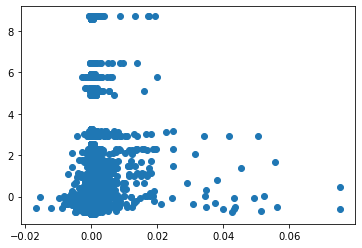

In [37]:
fig,ax = plt.subplots()

plt.scatter(reg_state['per_cap_arr_delta'],reg_state['change_x'])
# ax.set_xlim([0, 0.002])
# ax.set_ylim([0, 1])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f238dfcc5d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f238dfcce50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f238dfcc210>],
 'medians': [<matplotlib.lines.Line2D at 0x7f238dfba750>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f238dfbab90>],
 'means': []}

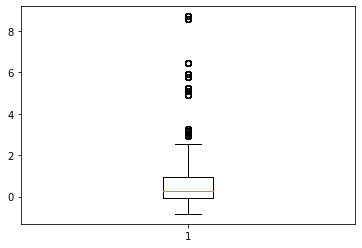

In [38]:
plt.boxplot(cleaned_6['change_x'])

In [39]:
np.percentile(reg_state['change_x'],q=95)

2.946512623020967

<h2>Hypothesis 1 - Simple Regression of Flight monthly_pax against totalTestResultsIncrease</h2>


In [71]:
covid_df.head()


,state,month,positiveIncrease,totalTestResultsIncrease,change,population,per_capita
0,AK,4,104,23414,-0.635088,737438,0.000141
1,AK,5,276,41705,1.653846,737438,0.000374
2,AK,6,915,76006,2.315217,737438,0.001241
3,AK,7,2498,146456,1.730055,737438,0.003387
4,AK,8,2272,107484,-0.090472,737438,0.003081


In [72]:
flight_df.head()


,origin_state,dest_state,month,monthly_pax
0,AK,AK,3.0,56336.281143
1,AK,AK,4.0,10187.576905
2,AK,AK,5.0,20472.748260
3,AK,AK,6.0,41179.674835
4,AK,AK,7.0,52228.927140


In [73]:
flight_dest_state = flight_df.groupby(['dest_state', 'month']).sum().reset_index()
flight_dest_state = flight_dest_state.rename(columns={'dest_state':'state'})
flight_dest_state.head()

,state,month,monthly_pax
0,AK,3.0,138235.631149
1,AK,4.0,26092.783185
2,AK,5.0,52663.559269
3,AK,6.0,110763.657546
4,AK,7.0,158323.464182


In [74]:
merged = covid_df.merge(flight_dest_state, how="inner", on=['state', 'month'])
merged.head()

,state,month,positiveIncrease,totalTestResultsIncrease,change,population,per_capita,monthly_pax
0,AK,4,104,23414,-0.635088,737438,0.000141,26092.783185
1,AK,5,276,41705,1.653846,737438,0.000374,52663.559269
2,AK,6,915,76006,2.315217,737438,0.001241,110763.657546
3,AK,7,2498,146456,1.730055,737438,0.003387,158323.464182
4,AK,8,2272,107484,-0.090472,737438,0.003081,151104.177926


In [75]:
regression_data = merged.drop(columns=['state','month','positiveIncrease','change','population','per_capita'])
regression_data.head()

,totalTestResultsIncrease,monthly_pax
0,23414,26092.783185
1,41705,52663.559269
2,76006,110763.657546
3,146456,158323.464182
4,107484,151104.177926


In [76]:
regression_data.shape

(294, 2)

In [77]:
model = sm.OLS(regression_data['totalTestResultsIncrease'],sm.add_constant(regression_data['monthly_pax']))
#model = sm.OLS(regression_data['totalTestResultsIncrease'],regression_data['monthly_pax'])
results = model.fit()
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     totalTestResultsIncrease   R-squared:                       0.618
Model:                                  OLS   Adj. R-squared:                  0.617
Method:                       Least Squares   F-statistic:                     473.2
Date:                      Fri, 02 Apr 2021   Prob (F-statistic):           4.89e-63
Time:                              09:38:47   Log-Likelihood:                -4170.7
No. Observations:                       294   AIC:                             8345.
Df Residuals:                           292   BIC:                             8353.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

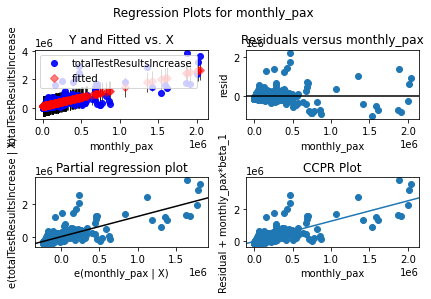

In [78]:
fig = sm.graphics.plot_regress_exog(results, "monthly_pax")
fig.tight_layout(pad=1.0)


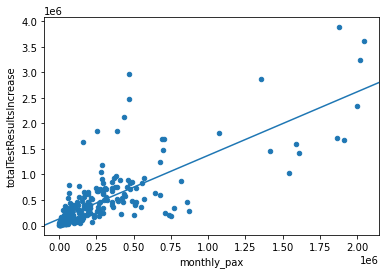

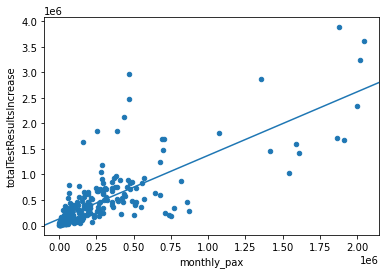

In [79]:
from statsmodels.graphics.regressionplots import abline_plot
# scatter-plot data
ax = regression_data.plot(x='monthly_pax', y='totalTestResultsIncrease', kind='scatter')

# plot regression line
abline_plot(model_results=results, ax=ax)
#abline_plot(intercept=results.params.const,slope=results.params.monthly_pax)

In [80]:
results.params

const          130731.428953
monthly_pax         1.243773
dtype: float64

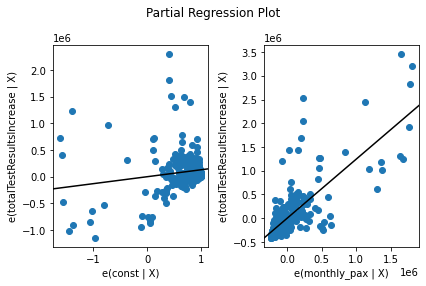

In [81]:
# partial regression plots of each variable
fig = sm.graphics.plot_partregress_grid(results)
fig.tight_layout(pad=1.0)



In [82]:
results.pvalues

const          1.930829e-07
monthly_pax    4.893081e-63
dtype: float64

<h2>Hypothesis 2 - Simple Regression of weighted flight monthly_pax against totalTestResultsIncrease</h2>
Weighed by per capita new COVID cases

In [83]:
merged['weighted_pax'] = merged['monthly_pax']*merged['per_capita']
merged

,state,month,positiveIncrease,totalTestResultsIncrease,change,population,per_capita,monthly_pax,weighted_pax
0,AK,4,104,23414,-0.635088,737438,0.000141,26092.783185,3.679834
1,AK,5,276,41705,1.653846,737438,0.000374,52663.559269,19.710325
2,AK,6,915,76006,2.315217,737438,0.001241,110763.657546,137.433583
3,AK,7,2498,146456,1.730055,737438,0.003387,158323.464182,536.305443
4,AK,8,2272,107484,-0.090472,737438,0.003081,151104.177926,465.542449
...,...,...,...,...,...,...,...,...,...
289,WY,5,359,17356,0.128931,577737,0.000621,5129.681877,3.187533
290,WY,6,891,29102,1.481894,577737,0.001542,16443.619638,25.359749
291,WY,7,1232,38808,0.382716,577737,0.002132,42210.523515,90.012177
292,WY,8,1209,37964,-0.018669,577737,0.002093,45547.705429,95.315301


In [84]:
regression_data = merged.drop(columns=['state','month','positiveIncrease','change','population','per_capita','monthly_pax'])
regression_data.head()

,totalTestResultsIncrease,weighted_pax
0,23414,3.679834
1,41705,19.710325
2,76006,137.433583
3,146456,536.305443
4,107484,465.542449


In [85]:
model = sm.OLS(regression_data['totalTestResultsIncrease'],sm.add_constant(regression_data['weighted_pax']))
results = model.fit()
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     totalTestResultsIncrease   R-squared:                       0.376
Model:                                  OLS   Adj. R-squared:                  0.373
Method:                       Least Squares   F-statistic:                     175.6
Date:                      Fri, 02 Apr 2021   Prob (F-statistic):           1.05e-31
Time:                              09:38:48   Log-Likelihood:                -4243.1
No. Observations:                       294   AIC:                             8490.
Df Residuals:                           292   BIC:                             8498.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

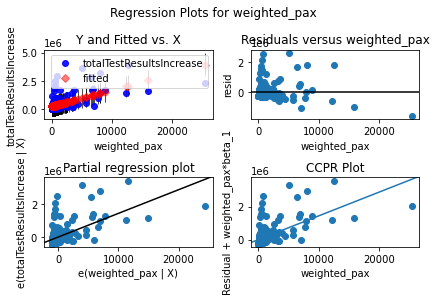

In [86]:
fig = sm.graphics.plot_regress_exog(results, "weighted_pax")
fig.tight_layout(pad=1.0)


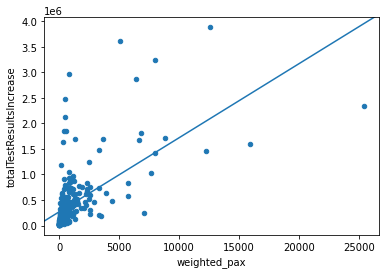

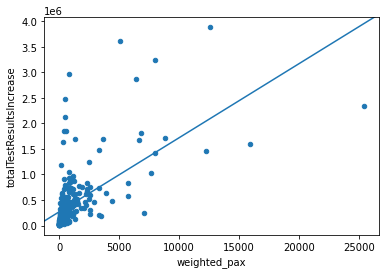

In [87]:
from statsmodels.graphics.regressionplots import abline_plot
# scatter-plot data
ax = regression_data.plot(x='weighted_pax', y='totalTestResultsIncrease', kind='scatter')

# plot regression line
abline_plot(model_results=results, ax=ax)
#abline_plot(intercept=results.params.const,slope=results.params.monthly_pax)

In [88]:
results.params

const           271967.597114
weighted_pax       144.911883
dtype: float64

In [89]:
results.pvalues

const           7.319818e-19
weighted_pax    1.049316e-31
dtype: float64

<h3>Hypothesis 3 - Adding in controls</h3>

In [90]:
merged

,state,month,positiveIncrease,totalTestResultsIncrease,change,population,per_capita,monthly_pax,weighted_pax
0,AK,4,104,23414,-0.635088,737438,0.000141,26092.783185,3.679834
1,AK,5,276,41705,1.653846,737438,0.000374,52663.559269,19.710325
2,AK,6,915,76006,2.315217,737438,0.001241,110763.657546,137.433583
3,AK,7,2498,146456,1.730055,737438,0.003387,158323.464182,536.305443
4,AK,8,2272,107484,-0.090472,737438,0.003081,151104.177926,465.542449
...,...,...,...,...,...,...,...,...,...
289,WY,5,359,17356,0.128931,577737,0.000621,5129.681877,3.187533
290,WY,6,891,29102,1.481894,577737,0.001542,16443.619638,25.359749
291,WY,7,1232,38808,0.382716,577737,0.002132,42210.523515,90.012177
292,WY,8,1209,37964,-0.018669,577737,0.002093,45547.705429,95.315301


In [91]:
merged['state_of_emergency'] = 0
merged['stay_at_home'] = 0
merged['business_closure'] = 0
merged['mask_mandate'] = 0
merged['quarantine_order'] = 0
merged = merged.rename(columns={'state':'dest_state'}) # rename to dest_state for use with helper function
merged.head()

,dest_state,month,positiveIncrease,totalTestResultsIncrease,change,population,per_capita,monthly_pax,weighted_pax,state_of_emergency,stay_at_home,business_closure,mask_mandate,quarantine_order
0,AK,4,104,23414,-0.635088,737438,0.000141,26092.783185,3.679834,0,0,0,0,0
1,AK,5,276,41705,1.653846,737438,0.000374,52663.559269,19.710325,0,0,0,0,0
2,AK,6,915,76006,2.315217,737438,0.001241,110763.657546,137.433583,0,0,0,0,0
3,AK,7,2498,146456,1.730055,737438,0.003387,158323.464182,536.305443,0,0,0,0,0
4,AK,8,2272,107484,-0.090472,737438,0.003081,151104.177926,465.542449,0,0,0,0,0


In [92]:
merged['state_of_emergency'] = merged.apply((lambda x: helpey(x, 'state_of_emergency')), axis=1)
merged['stay_at_home'] = merged.apply((lambda x: helpey(x, 'stay_at_home')), axis=1)
merged['business_closure'] = merged.apply((lambda x: helpey(x, 'business_closure')), axis=1)
merged['mask_mandate'] = merged.apply((lambda x: helpey(x, 'facemask_mandate')), axis=1)
merged['quarantine_order'] = merged.apply((lambda x: helpey(x, 'quaratine_mandate')), axis=1)
merged

,dest_state,month,positiveIncrease,totalTestResultsIncrease,change,population,per_capita,monthly_pax,weighted_pax,state_of_emergency,stay_at_home,business_closure,mask_mandate,quarantine_order
0,AK,4,104,23414,-0.635088,737438,0.000141,26092.783185,3.679834,1,0,0,1,0
1,AK,5,276,41705,1.653846,737438,0.000374,52663.559269,19.710325,1,0,0,0,0
2,AK,6,915,76006,2.315217,737438,0.001241,110763.657546,137.433583,1,0,0,0,0
3,AK,7,2498,146456,1.730055,737438,0.003387,158323.464182,536.305443,1,0,0,0,0
4,AK,8,2272,107484,-0.090472,737438,0.003081,151104.177926,465.542449,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,WY,5,359,17356,0.128931,577737,0.000621,5129.681877,3.187533,1,0,0,0,0
290,WY,6,891,29102,1.481894,577737,0.001542,16443.619638,25.359749,1,0,0,0,0
291,WY,7,1232,38808,0.382716,577737,0.002132,42210.523515,90.012177,1,0,0,0,0
292,WY,8,1209,37964,-0.018669,577737,0.002093,45547.705429,95.315301,1,0,0,0,0


<h4>OLS with monthly pax</h4>

In [93]:
# ols with monthly pax
# NOTE add constant does not add a new row, because state_of_emergency is a constant column - all 1s.
model = sm.OLS(merged['totalTestResultsIncrease'], sm.add_constant(merged[['monthly_pax','state_of_emergency','stay_at_home','business_closure','mask_mandate','quarantine_order']]))
#model = sm.OLS(merged['totalTestResultsIncrease'], sm.add_constant(merged[['monthly_pax','state_of_emergency','stay_at_home','business_closure','mask_mandate','quarantine_order']],has_constant='add'))
results = model.fit()
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     totalTestResultsIncrease   R-squared:                       0.651
Model:                                  OLS   Adj. R-squared:                  0.645
Method:                       Least Squares   F-statistic:                     107.3
Date:                      Fri, 02 Apr 2021   Prob (F-statistic):           1.18e-63
Time:                              09:38:50   Log-Likelihood:                -4157.7
No. Observations:                       294   AIC:                             8327.
Df Residuals:                           288   BIC:                             8350.
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

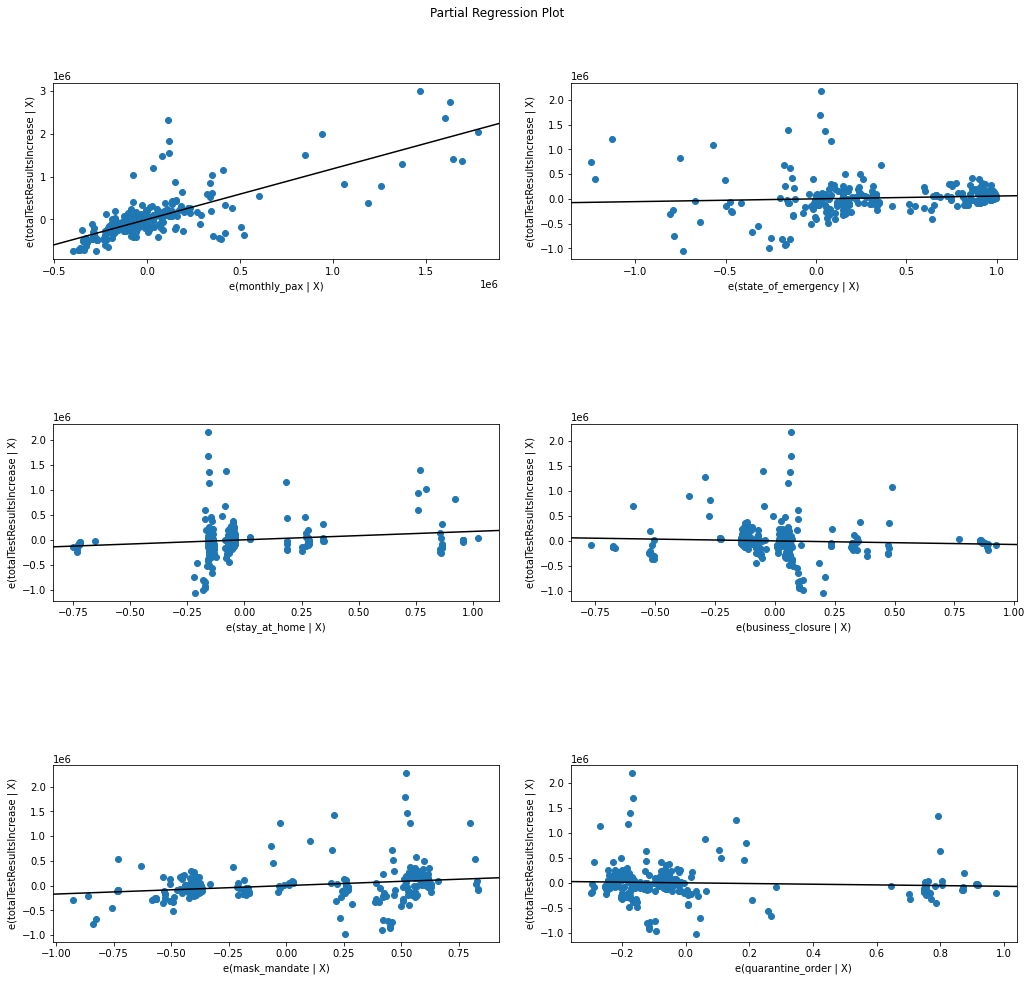

In [94]:
# partial regression plot for each variable
fig = sm.graphics.plot_partregress_grid(results)
fig.tight_layout(pad=0.1)
fig.set_figheight(15)
fig.set_figwidth(15)

In [95]:
results.params

monthly_pax                1.181916
state_of_emergency     56555.990554
stay_at_home          167837.748023
business_closure      -71591.423066
mask_mandate          171340.979610
quarantine_order      -69363.009350
dtype: float64

In [96]:
results.pvalues

monthly_pax           1.753227e-57
state_of_emergency    8.238890e-02
stay_at_home          7.542886e-03
business_closure      3.073764e-01
mask_mandate          8.407354e-05
quarantine_order      2.736742e-01
dtype: float64

<h4>OLS with weighted pax</h4>

In [97]:
# ols with monthly pax
# NOTE add constant does not add a new row, because state_of_emergency is a constant column - all 1s.
model = sm.OLS(merged['totalTestResultsIncrease'], sm.add_constant(merged[['weighted_pax','state_of_emergency','stay_at_home','business_closure','mask_mandate','quarantine_order']]))
#model = sm.OLS(merged['totalTestResultsIncrease'], sm.add_constant(merged[['weighted_pax','state_of_emergency','stay_at_home','business_closure','mask_mandate','quarantine_order']],has_constant='add'))
results = model.fit()
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     totalTestResultsIncrease   R-squared:                       0.472
Model:                                  OLS   Adj. R-squared:                  0.462
Method:                       Least Squares   F-statistic:                     51.40
Date:                      Fri, 02 Apr 2021   Prob (F-statistic):           5.60e-38
Time:                              09:38:50   Log-Likelihood:                -4218.5
No. Observations:                       294   AIC:                             8449.
Df Residuals:                           288   BIC:                             8471.
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

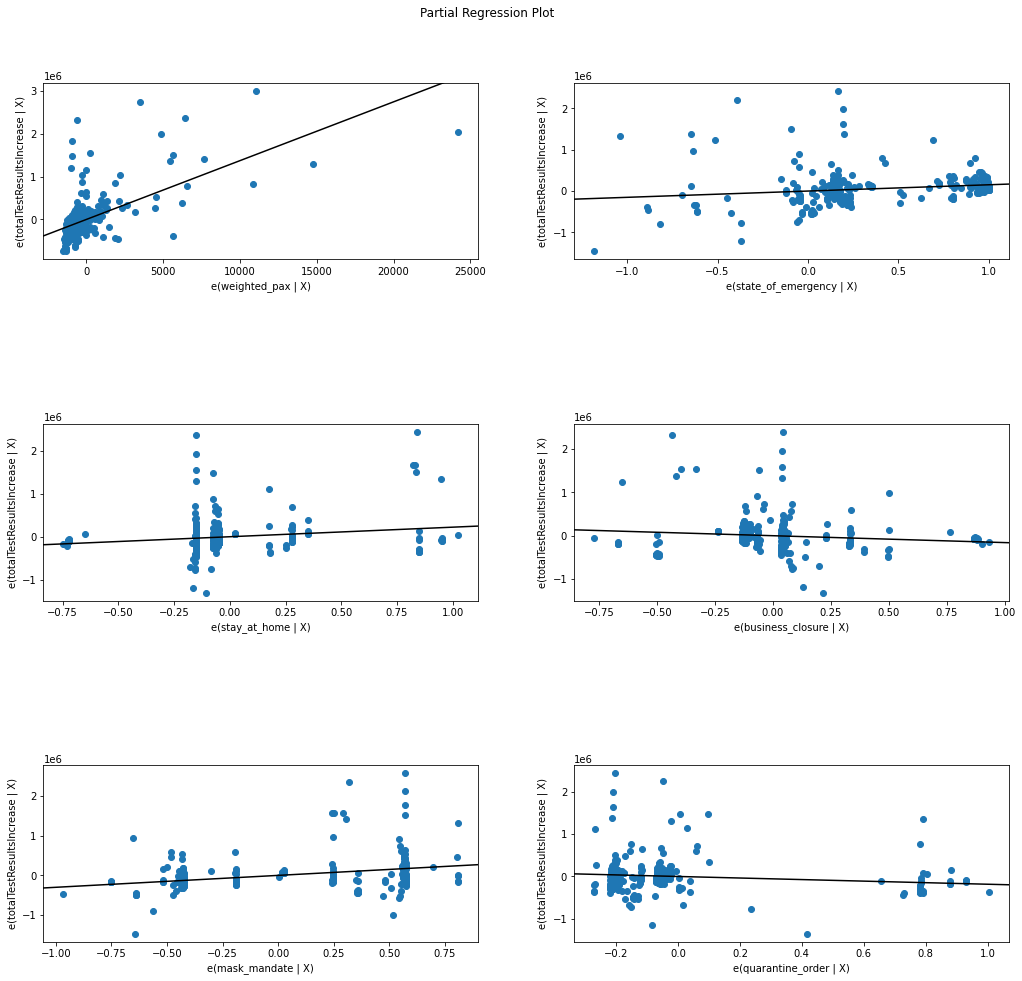

In [98]:
# partial regression plot for each variable
fig = sm.graphics.plot_partregress_grid(results)
fig.tight_layout(pad=0.1)
fig.set_figheight(15)
fig.set_figwidth(15)

In [99]:
results.params

weighted_pax             136.921861
state_of_emergency    152014.282576
stay_at_home          223179.793688
business_closure     -158816.921330
mask_mandate          300022.039872
quarantine_order     -183768.992685
dtype: float64

In [100]:
results.pvalues

weighted_pax          1.664533e-31
state_of_emergency    1.081015e-04
stay_at_home          3.852195e-03
business_closure      6.476797e-02
mask_mandate          2.038823e-08
quarantine_order      1.760021e-02
dtype: float64